# GAN Project
## Liz Parker, Colin Craighead, and Aren Dalloul

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras.optimizers import Adam
import tensorflow.keras.preprocessing.image as img
import scipy.io
import random
from PIL import Image

Using TensorFlow backend.


## Preparing the Dataset

In [3]:
test_mat = scipy.io.loadmat("data/test_data.mat")
train_mat = scipy.io.loadmat("data/train_data.mat")

In [4]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    breeds = []
    breed_ids = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "data/images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        temp_arr = mat[train_or_test][0][0][1][i][0][0].strip().split('-')
        breed_str = "-".join(temp_arr[1:]).split('/')[0]
        breeds.append(breed_str)
        breed_ids.append(mat[train_or_test][0][0][2][i][0])
    df['breed'] = breeds
    df['breed_id'] = breed_ids
    df['path'] = paths
    return df

In [9]:
train_df = unpack_mat(train_mat, 'train_info')
test_df = unpack_mat(test_mat, 'test_info')
train_df.head()

#TO REMOVE !!!!!!!!!!!!!
train_df = train_df.truncate(after = 1000)
test_df = test_df.truncate(after = 1000)

In [10]:
X_train = np.array([img.img_to_array(img.load_img(path, target_size = (400,400))) for path in train_df['path']])


In [11]:
X_test = np.array([img.img_to_array(img.load_img(path, target_size = (400,400))) for path in test_df['path']])

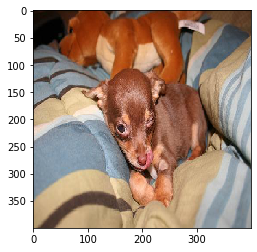

In [59]:
plt.imshow(X_test[0].astype('uint8'))

In [114]:
#Build discriminator
#discriminator is normal neural network model for binary classification

discriminator = models.Sequential()
discriminator.add(layers.Conv2D(128,(2,2), strides=(2, 2), input_shape=(400,400,3)))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Conv2D(128,(2,2), strides=(2, 2)))
discriminator.add(layers.LeakyReLU(alpha=0.2))
#discriminator.add(layers.Dropout(0.4))
#discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 200, 200, 128)     1664      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 200, 200, 128)     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 100, 128)     65664     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 100, 100, 128)     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280000)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 1280001   
Total params: 1,347,329
Trainable params: 1,347,329
Non-trainable params: 0
___________________________________________

In [115]:
#Build Generator
latentDim = 100 #Common practice
nodes = 128 * 100 * 100 # representing 100 x 100 image 1/4 the size of real 400 x 400 images
generator = models.Sequential()
generator.add(layers.Dense(nodes, input_dim = latentDim))
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.Reshape((100, 100, 128)))

#Upsample to 200x200
generator.add(layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
generator.add(layers.LeakyReLU(alpha=0.2))
#generator.add(layers.BatchNormalization(momentum=0.8)) 

#Upsample to 400x400
generator.add(layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
generator.add(layers.LeakyReLU(alpha=0.2))
#generator.add(layers.BatchNormalization(momentum=0.8)) 

#activation
generator.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
generator.summary()
               

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1280000)           129280000 
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 1280000)           0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 200, 200, 128)     147584    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 200, 200, 128)     0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 400, 400, 128)     147584    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 400, 400, 128)   

In [98]:
# opt = Adam(lr=0.0002, beta_1=0.5)
# generator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [131]:
# Get noise from latent space for generator input
def getGenInput(sampleSZ):
    val = np.random.randn(latentDim, int(sampleSZ))
    val = val.reshape(int(sampleSZ), latentDim)
    return val

# genInput = getGenInput(5)
# print(latentDim)
# print(genInput.shape)
# fakeSample = generator.predict(genInput)
# print(fakeSample.shape)

100
(5, 100)
(5, 400, 400, 3)


In [117]:
#Using these cells for debugging
# print(genInput.shape)
# print(genInput[0])

In [136]:
# print(fakeSample.shape)
# x = X_train[0]

# sm = 5
# sz= 100

# indices = random.sample(range(sz), k=int(sm))
# realSample = X_train[indices]
# a = np.vstack((realSample, fakeSample))
# print(a.shape)
# l1 = np.zeros((int(a.shape[0]/2),), dtype = int)
# l2 = np.zeros((int(a.shape[0]/2),), dtype = int)
# label = np.vstack((l1, l2))
# better = np.zeros((a.shape[0],), dtype = int)
# print(label.shape)
# print(better.shape)

(5, 400, 400, 3)
(10, 400, 400, 3)
(2, 5)
(10,)


In [133]:
# opt = Adam(lr=0.0002, beta_1=0.5)
# discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# discriminator.train_on_batch(a, label)

[0.34339565, 1.0]

In [120]:
# Define GAN
nonTrainableDis = models.clone_model(discriminator)
nonTrainableDis.trainable = False #weights of disciminator cannot be changed in GAN
GAN = models.Sequential()
GAN.add(generator)
GAN.add(nonTrainableDis)
opt = Adam(lr=0.0002, beta_1=0.5)
GAN.compile(loss='binary_crossentropy', optimizer=opt)
GAN.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 400, 400, 3)       129584771 
_________________________________________________________________
sequential_22 (Sequential)   (None, 1)                 1347329   
Total params: 130,932,100
Trainable params: 129,584,771
Non-trainable params: 1,347,329
_________________________________________________________________


In [ ]:
#Train
#The discriminator is trained to minimize the binary cross entropy loss function
#This is fitting for a binary classification
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 5
batches = 5
datasetSZ = X_train.shape[0]
sampleSZ = datasetSZ//4

# Loop through epochs
for i in range(epochs):
    # Loop through batches
    for j in range(batches):
        # Random sample of real images
        indices = random.sample(range(datasetSZ), k=int(sampleSZ))
        realSample = X_train[indices]
        realLabel = np.ones((int(sampleSZ),), dtype = int)
        
        # Generate sample of fake images
        genInput = getGenInput(int(sampleSZ))
        fakeSample = generator.predict(genInput)
        fakeLabel = np.zeros((int(sampleSZ),), dtype = int)
        
        # create training set for the discriminator
        X = np.vstack((realSample, fakeSample))
        y = np.append(realLabel, fakeLabel)#np.vstack((realLabel, fakeLabel))
        #print(X.shape)
        #print(y.shape)
        # Train the discriminator
        disLoss, _ = discriminator.train_on_batch(X, y)
        
        # Create training set for the GAN
        X = getGenInput(int(sampleSZ))
        y = np.ones((int(sampleSZ),), dtype = int)
        #Train the GAN
        GANloss = GAN.train_on_batch(X, y)
        if batch%30 == 0:
            print('epoch:%d, batch:%d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batches, disLoss, GANloss))
        
    #Summarize performance after each epoch
    
    #Discriminator performance can be calculated
    indices = random.sample(range(datasetSZ), k=int(sampleSZ))
    realSample = X_test[indices]
    realLabel = np.ones((int(sampleSZ),), dtype = int)
    _, accReal = discriminator.evaluate(realSample, realLabel, verbose=0)
    genInput = getGenInput(int(sampleSZ))
    fakeSample = generator.predict(genInput)
    fakeLabel = np.zeros((int(sampleSZ),), dtype = int)
    _, accFake = discriminator.evaluate(fakeSample, fakeLabel, verbose=0)
    print('Discriminator Accuracy real: %.0f%%, fake: %.0f%%' % (accReal*100, accFake*100))
    
    #Look at generator performance
    plt.figure()
    plt.imshow(fakeSample[0].astype('uint8'))
    


(500, 400, 400, 3)
(500,)
